# Predicting Option Prices

Directory
1. [The Black Scholes Model](#1)
2. [The Setup](#2)
3. [Calculating Implied Volatility](#3)
4. [Predicting and Evaluating](#4)

In [1]:
import numpy as np
import pandas as pd
from math import log, exp, sqrt
from scipy.stats import norm
from datetime import datetime, date

## The Black Scholes Model <a name="1"></a>

The price of a call is given by: <br>
#### $ C_0 = S_0 N(d_1) - Ee^{-rT}N(d_2)$
where... <br>
$S_0$ = current stock price, and $E$ = exercise price <br>
$N(d_i) = P($standard normal random variable $\leq d_i)\ $  i.e. normal CDF <br>
$d_1 = \frac{ln(S_0/E) + (r + \sigma^2 / 2)T}{\sigma \sqrt{T}}$, 
$d_2 = d_1 - \sigma \sqrt{T}$ <br>
$\sigma$ = std. of the stock's annual return (continuously compounded) <br>
$r$ = annual risk free rate (continuously compounded)<br>
$T$ = years to maturity <br>

Assumptions:
1. The option is European - it cannot be exercised before maturity
2. The underlying asset does not pay a dividend
3. Markets are efficient and no arbitrage opportunities exist
4. The returns on the underlying asset are normally distributed
5. The risk-free rate and volatility are constant

## Setup <a name="2"></a>

In [2]:
N = norm.cdf
n = norm.pdf

def call(S, E, r, sigma, T): 
    d1 = (log(S / E) + (r + sigma**2 / 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    call = S * N(d1) - E * exp(-r*T) * N(d2)
    return round(call, 8)

def put(S, E, r, sigma, T):
    d1 = (log(S / E) + (r + sigma**2 / 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    put = E * exp(-r*T) * (1 - N(d2)) - S * (1 - N(d1))
    return round(put, 8)

In [3]:
# Combine the above with an additional parameter
def price(S, E, r, sigma, T, option):
    d1 = (log(S / E) + (r + sigma**2 / 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    
    if option == 'c':
        price = S * N(d1) - E * exp(-r*T) * N(d2)
    else:
        price = E * exp(-r*T) * (1 - N(d2)) - S * (1 - N(d1))
    return round(price, 8)

In [4]:
# Test the function
S = 36400
E = 30000
r = 0.05
sigma = 0.53
T = 1
price(S, E, r, sigma, T, 'c')

11399.73195256

In [5]:
# load data (source: https://finance.yahoo.com/quote/TSLA/history?p=TSLA)
data = pd.read_csv(r'C:\Users\Summe\Code\data\TSLA.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-19,184.699997,188.955994,180.203995,183.483994,183.483994,127115000
1,2020-02-20,182.389999,182.399994,171.988007,179.882004,179.882004,88174500
2,2020-02-21,181.395996,182.612000,176.089996,180.199997,180.199997,71574000
3,2020-02-24,167.800003,172.699997,164.440002,166.757996,166.757996,75961000
4,2020-02-25,169.800003,171.320007,157.399994,159.981995,159.981995,86452500
...,...,...,...,...,...,...,...
249,2021-02-12,801.260010,817.330017,785.330017,816.119995,816.119995,23701700
250,2021-02-16,818.000000,821.000000,792.440002,796.219971,796.219971,19686700
251,2021-02-17,779.090027,799.840027,762.010010,798.150024,798.150024,25996500
252,2021-02-18,780.900024,794.690002,776.270020,787.380005,787.380005,17897000


In [6]:
# check for NAs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       254 non-null    object 
 1   Open       254 non-null    float64
 2   High       254 non-null    float64
 3   Low        254 non-null    float64
 4   Close      254 non-null    float64
 5   Adj Close  254 non-null    float64
 6   Volume     254 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.0+ KB


Needless to say, Tesla's options are not settled European style. <br>
Let's pretend they are for the time being... because I was unable to find data on European options, and when I eventually found some, I was unable to find the money to pay for it.

## Calculating Implied Volatility <a name="3"></a>

Method 1: using Newton's method for root approximation
- iterate over values of $\sigma$ 
- calculate slope of the tangent line evaluated at each iteration point $ $
- repeat until the approximation is close enough to the true root $ $ 

In [7]:
# Find vega which measures price sensitivity to changes in iv (partial derivative of C w.r.t. sigma)
def vega(S, E, r, sigma, T):
    d1 = (log(S / E) + (r + sigma ** 2 / 2) * T) / (sigma * sqrt(T))
    deriv = S * n(d1) * np.sqrt(T)
    return deriv 

In [8]:
# Implement Newton's method
def iv(targetVal, S, E, r, T):
    sigma = 0.5      # starting test value
    EPSILON = 1.0e-5 # precision tolerance
    MAX_ITER = 200    
    
    for i in range(0, MAX_ITER):
        price = call(S, E, r, sigma, T)
        v = vega(S, E, r, sigma, T) # f'(x)
        diff = price - targetVal       # f(x)
        if (abs(diff) < EPSILON):
            return sigma # satisfactory estimate found
        sigma = sigma - diff/v      # x1 = x0 - f(x0) / f'(x0)
    return sigma         # satisfactory estimate not found within MAX_ITER

In [9]:
# Test the function
targetVal = call(S, E, r, sigma, T)
implied_vol = iv(targetVal, S, E, r, T)
implied_vol

0.5300000000002799

With large datasets, method 1 can be computationally expensive. <br>
Try method 2: calculating stock returns and taking standard deviation directly

In [10]:
# Calculate returns
data = data.assign(Return = (data.Close - data.Close.shift(1)) / data.Close.shift(1))
data.describe()

,Open,High,Low,Close,Adj Close,Volume,Return
count,254.000000,254.000000,254.000000,254.000000,254.000000,2.540000e+02,253.000000
mean,380.116466,389.655890,369.957252,380.861637,380.861637,6.467769e+07,0.007157
std,232.561731,236.803456,228.210010,233.493858,233.493858,3.368546e+07,0.053106
min,74.940002,80.972000,70.101997,72.244003,72.244003,1.515770e+07,-0.210628
25%,165.891998,167.414501,161.790005,163.924504,163.924504,3.878098e+07,-0.020635
50%,356.300003,369.085999,338.038010,366.703995,366.703995,5.977230e+07,0.003716
75%,474.284996,499.105011,446.387504,483.742508,483.742508,8.484608e+07,0.034152
max,891.380005,900.400024,871.599976,883.090027,883.090027,2.221262e+08,0.183877


In [11]:
# Calculate iv
iv = np.sqrt(365) * data['Return'].std()
iv

1.014587272554538

## Predicting and Evaluating <a name="4"></a>

In [12]:
# Load data for calls with exercise date = Feb 26, 2021
calls = pd.read_html('https://finance.yahoo.com/quote/TSLA/options?date=1614297600&p=TSLA')[0]
calls['Implied Volatility'] = calls['Implied Volatility'].str.rstrip('%').astype('float') / 100.0
calls.describe()

,Strike,Last Price,Bid,Ask,Change,Volume,Open Interest,Implied Volatility
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,917.764550,62.367354,61.059683,62.057566,-3.236243,711.338624,504.608466,0.893252
std,314.265115,122.323555,119.737958,120.766869,4.813903,1893.182520,903.999562,0.465831
min,200.000000,0.010000,0.000000,0.020000,-22.730000,1.000000,1.000000,0.457300
25%,747.500000,0.100000,0.050000,0.150000,-6.550000,12.000000,85.000000,0.505600
50%,865.000000,1.560000,1.450000,1.630000,-1.020000,128.000000,211.000000,0.702600
75%,1110.000000,40.770000,41.550000,43.300000,-0.050000,518.000000,510.000000,1.240200
max,1700.000000,581.900000,579.850000,582.850000,10.150000,15141.000000,6603.000000,3.195300


In [13]:
# Predict prices!
days = 7 # time until maturity
spot = 781 # (source: https://finance.yahoo.com/quote/%5EGSPC/)
rf = 1.2870 # (source: https://finance.yahoo.com/quote/%5ETNX?p=%5ETNX)
prediction = []
for i in range(0, len(dec)):
    price = call(spot, dec['Strike'][i], rf, dec['Implied Volatility'][i], days/365)
    prediction.append(price)

In [14]:
dec = dec.assign(Predicted_Price = prediction)
dec

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Predicted_Price
0,TSLA210226C00200000,2021-02-17 9:55AM EST,200.0,581.90,579.85,582.85,-3.60,-0.61%,20,1,3.1953,585.915903
1,TSLA210226C00250000,2021-02-19 12:51PM EST,250.0,530.60,529.85,532.85,3.00,+0.57%,3,9,2.6875,537.133787
2,TSLA210226C00350000,2021-02-17 1:23PM EST,350.0,433.92,429.90,432.85,0.00,-,3,14,1.9922,439.587267
3,TSLA210226C00360000,2021-02-10 2:36PM EST,360.0,453.00,419.90,422.95,0.00,-,5,7,2.0195,429.867845
4,TSLA210226C00370000,2021-02-12 9:35AM EST,370.0,417.80,409.90,412.90,-7.25,-1.71%,2,14,1.9102,420.091736
...,...,...,...,...,...,...,...,...,...,...,...,...
184,TSLA210226C01600000,2021-02-19 3:36PM EST,1600.0,0.02,0.02,0.03,0.00,-,15,100,1.5469,0.038609
185,TSLA210226C01625000,2021-02-18 2:17PM EST,1625.0,0.03,0.01,0.05,0.00,-,21,113,1.5938,0.043971
186,TSLA210226C01650000,2021-02-19 1:40PM EST,1650.0,0.02,0.01,0.02,-0.02,-50.00%,10,205,1.5469,0.022706
187,TSLA210226C01675000,2021-02-19 11:37AM EST,1675.0,0.02,0.01,0.02,0.00,-,8,211,1.5781,0.023149


In [15]:
dec['Dif'] = ((dec['Last Price'] - dec['Predicted_Price'])/dec['Predicted_Price'])*100
dec['Dif'].describe()

count    189.000000
mean     -32.365753
std       23.570319
min      -83.944688
25%      -51.865062
50%      -35.129126
75%      -13.873142
max      113.641980
Name: Dif, dtype: float64

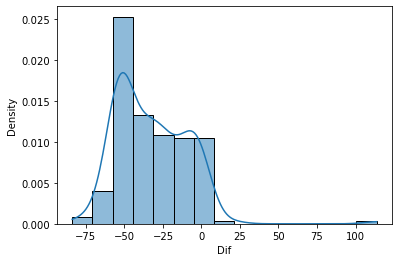

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(dec['Dif'], stat = "density", kde = True)
plt.show()

With a standard deviation of 24% and an average error of 32%, the Black Scholes Model did not produce highly accurate predictions when benchmarked against the last transaction prices. <br>

This was expected, however, since the model assumes many unrealistic settings. <br>

In these uncertain times, the model assumes <em> constant </em> volatility and risk free rate when they are more dynamic than ever. <br>

Additionally, the model assumes that the asset's returns are normally distributed - this is not always the case. Without knowing the shape of the distribution, how heavy the tails are, getting an accurate prediction is a difficult feat. <br>

Last but not least, the model is meant to be used on European options only. With that said, this flawed implementation of the Black Scholes Model turned out to be relatively accurate, considering the current market conditions and the model's limitations.

